In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import gzip, pickle
from torch_geometric.data import DataLoader
from gnn_model import GNN, BaselineGCN1, BaselineGCN2
import config
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import torch
import gnn_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [19]:
# load data
with gzip.open(config.gnn_data_dir+"train.pkl.gz", "rb") as f:
    train_X = pickle.load(f)
with gzip.open(config.gnn_data_dir+"val.pkl.gz", "rb") as f:
    val_X = pickle.load(f)
with gzip.open(config.gnn_data_dir+"test.pkl.gz", "rb") as f:
    test_X = pickle.load(f)
bs = config.bs
train_loader_no_shuffle = DataLoader(train_X, batch_size = bs, shuffle=False, drop_last=False)
val_loader_no_shuffle = DataLoader(val_X, batch_size = bs, shuffle=False, drop_last=False)
test_loader = DataLoader(test_X, batch_size=bs, shuffle=False, drop_last=False)

In [24]:
# load the best model    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = BaselineGCN1(n_features = config.n_features).to(device)
model1.load_state_dict(torch.load( config.best_model1 ))

model2 = BaselineGCN2(n_features = config.n_features).to(device)
model2.load_state_dict(torch.load( config.best_model2 ))

model3 = BaselineGCN2(n_features = config.n_features).to(device)
model3.load_state_dict(torch.load( config.best_model3 ))

<All keys matched successfully>

train results
r2: 0.8477
rmse: 0.8608
sp: 0.9205
mae: 0.5942


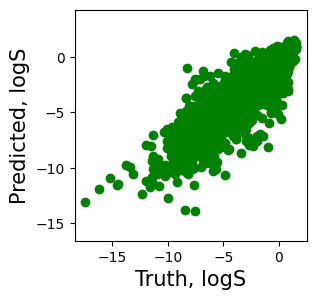

valid results
r2: 0.8251
rmse: 0.9139
sp: 0.9105
mae: 0.6211


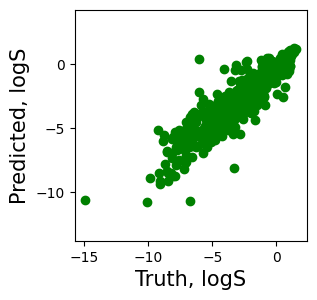

test results
r2: 0.8310
rmse: 0.8930
sp: 0.9034
mae: 0.6341


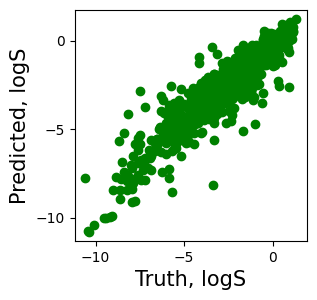

In [ ]:
# make predictions
gnn_utils.get_results('train', train_loader_no_shuffle, model2, device)
gnn_utils.get_results('valid', val_loader_no_shuffle, model2, device)
gnn_utils.get_results('test', test_loader, model2, device)


In [33]:
def collect_predictions(loader, model, device):
    model.eval()
    rows = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predict (test)", leave=False):
            batch = batch.to(device)
            pred = model(batch).reshape(-1,)
            # 移回CPU转为numpy
            pred_np = pred.detach().cpu().numpy()
            y_np    = batch.y.detach().cpu().numpy()
            # 有的话取 idx（create_data_list()/creatData 里通常会存）
            if hasattr(batch, "idx"):
                idx_np = batch.idx.detach().cpu().numpy()
            else:
                # 兜底：如果没有 idx，就用累计编号
                start = len(rows)
                idx_np = np.arange(start, start + len(pred_np), dtype=int)

            for i in range(len(pred_np)):
                e = float(pred_np[i] - y_np[i])
                rows.append({
                    "idx":    int(idx_np[i]),
                    "y_true": float(y_np[i]),
                    "y_pred": float(pred_np[i]),
                    "abs_err": abs(e),
                    "sq_err":  e*e
                })
    return pd.DataFrame(rows)

# 1) 收集预测
model = model2
df_pred = collect_predictions(test_loader, model, device)

# 2) 读入 test.csv 以便附加元信息（smiles/cas/temp/...）
test_csv_path = config.data_dir + "test.csv"
df_meta = pd.read_csv(test_csv_path)

# 3) 尝试按 idx 对齐并拼接可读列
cols_meta = [c for c in ["smiles","inchi","cas","ref","temp"] if c in df_meta.columns]
# 这里假设 creatData 里的 idx 对应 test.csv 的行号（常见做法）
meta_rows = df_meta.iloc[df_pred["idx"].values].reset_index(drop=True)
df_pred_meta = pd.concat(
    [df_pred.reset_index(drop=True),
     meta_rows[cols_meta] if cols_meta else meta_rows.reset_index(drop=True)],
    axis=1
)

# 4) 取绝对误差最大的前10个
worst10 = df_pred_meta.sort_values("abs_err", ascending=False).head(10)

# 5) 打印关键信息 & 保存
display_cols = [c for c in ["idx","smiles","cas","y_true","y_pred","abs_err","sq_err"] if c in worst10.columns]
print("Top-10 worst predictions in the test set (by absolute error):")
print(worst10[display_cols].to_string(index=False))

Top-10 worst predictions in the test set (by absolute error):
 idx                                                                      smiles          cas    y_true    y_pred   abs_err     sq_err
 181                                                   CCc1ccc2c(c1)C(=O)C(=O)N2  000980-26-7 -7.495313 -2.652954  4.842359  23.448437
 612                           CCc1cc(Cc2cc(CC)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1  000088-24-4 -8.699628 -4.757112  3.942516  15.543435
   8                                     c1ccc(C(c2ccccc2)(c2ccccc2)N2CCOCC2)cc1  001420-06-0 -7.216800 -3.479721  3.737079  13.965761
 769  O=S(=O)(O)c1ccccc1Nc1ccc(C(=C2C=CC(=Nc3ccccc3)C=C2)c2ccc(Nc3ccccc3)cc2)cc1  001324-76-1 -8.377098 -4.768499  3.608599  13.021985
  92                                              COC(=O)C1CC(=O)C(C(=O)OC)CC1=O  006289-46-9 -4.154198 -0.711394  3.442804  11.852898
 456                                                            Clc1ccc(Br)cc1Cl  018282-59-2 -1.011493 -4.450179  3.438686  11.